# import libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd

# import dataset

In [2]:
# import dataset
insurance_df = pd.read_csv('insurance.csv')

# make a copy of the original dataset
insurance = insurance_df.copy()

In [3]:
# initial look at the data
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# basic info about the data
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# basisc statistical details about the data
insurance.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [6]:
#  basic statistical details about categorical columns
insurance.describe(include='O').transpose()

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [7]:
# list catagorical unique values
for col in insurance.select_dtypes(include='object'):
    print(f'{col} : {insurance[col].unique()}')

sex : ['female' 'male']
smoker : ['yes' 'no']
region : ['southwest' 'southeast' 'northwest' 'northeast']


# data cleaning & EDA

In [8]:
# check for missing values
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

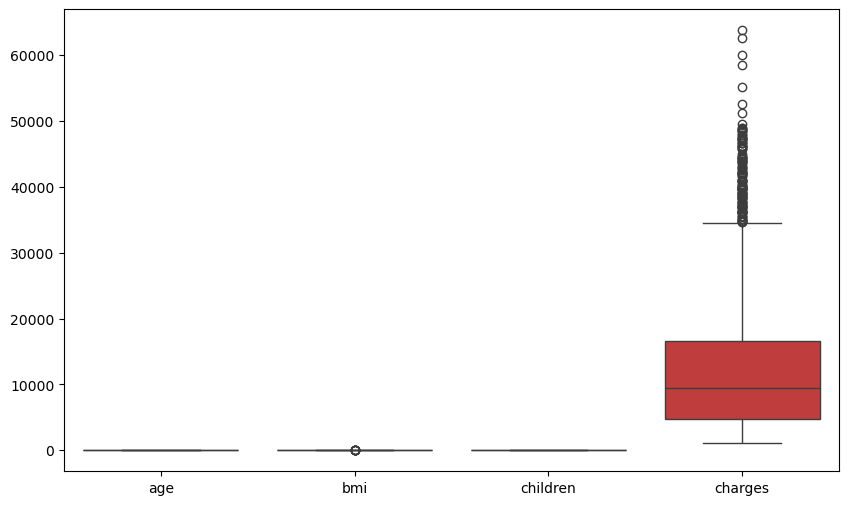

In [9]:
# check for outliers using boxplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,6))
sns.boxplot(data=insurance)
plt.show()


In [10]:
# categorical data onehot encoding
insurance = pd.get_dummies(insurance, drop_first=True)
insurance.head()
# helps with plotting graphs inline

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


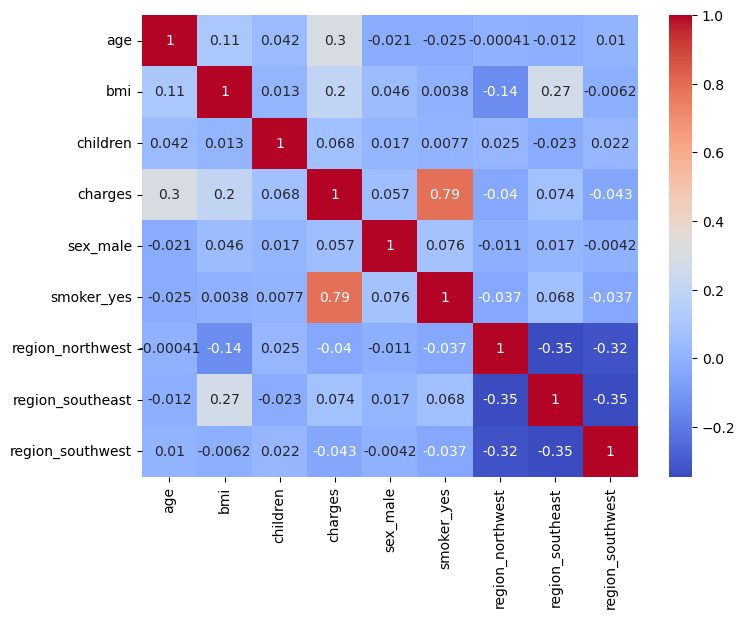

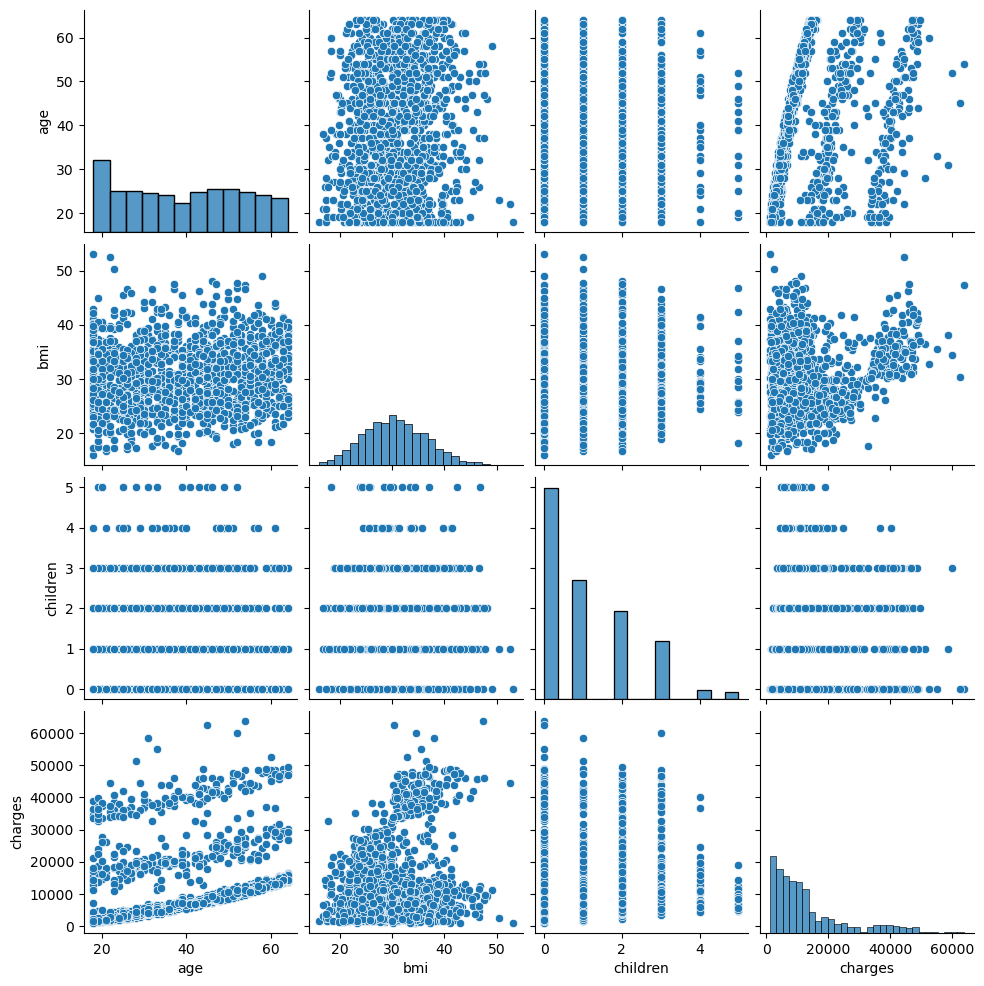

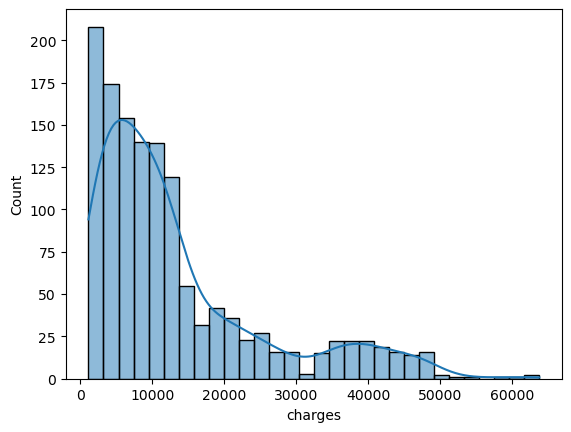

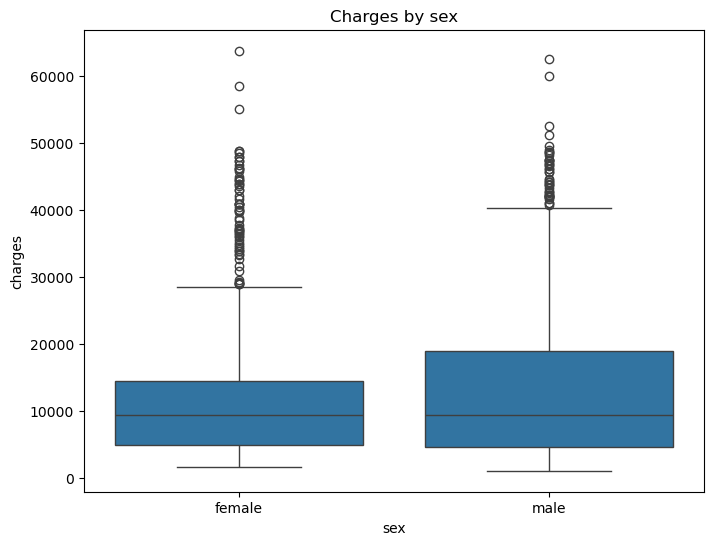

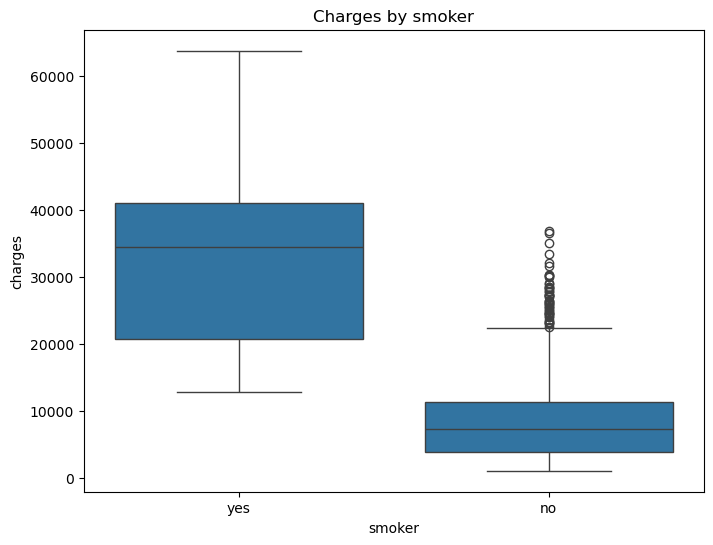

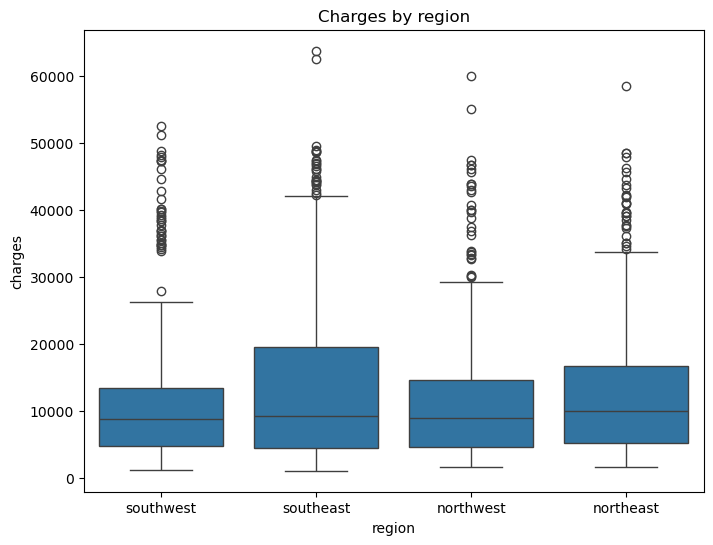

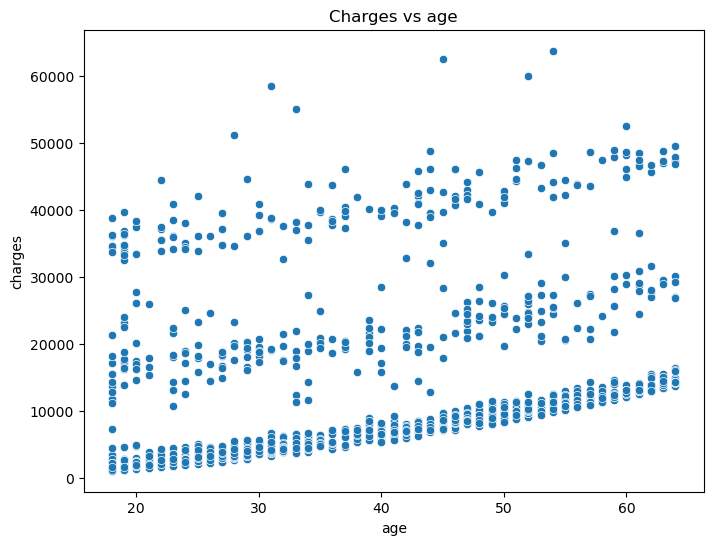

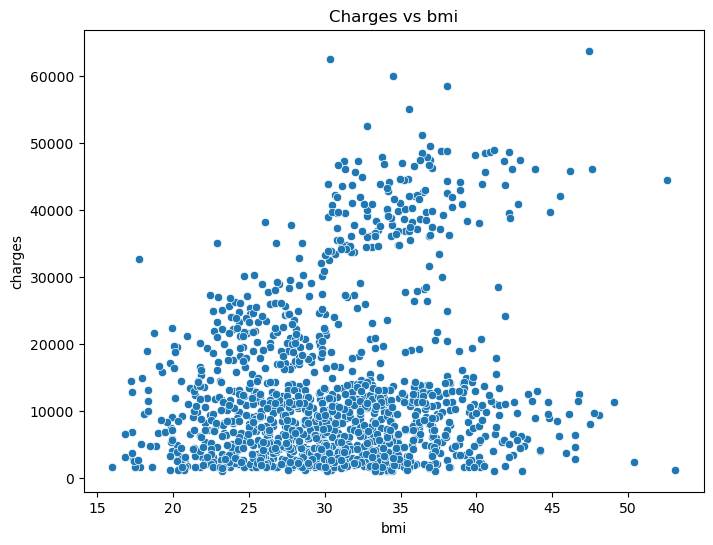

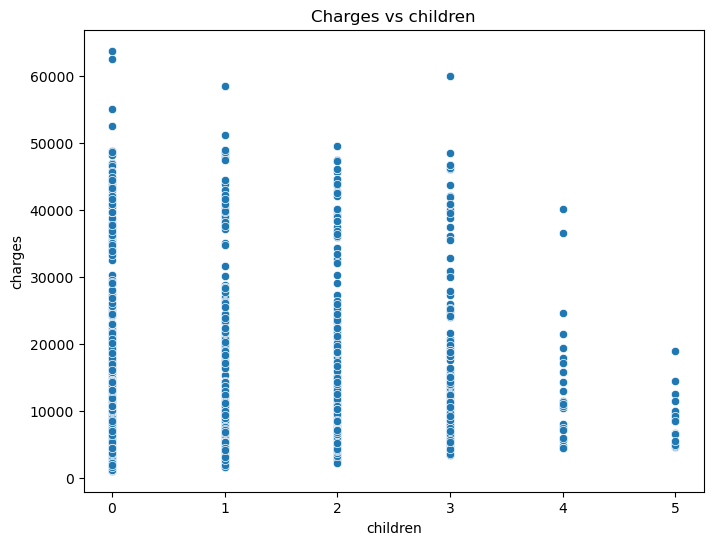

In [11]:
# correlation matrix
insurance.corr()
plt.figure(figsize=(8,6))
sns.heatmap(insurance.corr(), annot=True, cmap='coolwarm')
plt.show()

# pairplot (use original dataframe to retain categorical columns)
sns.pairplot(insurance_df)
plt.show()

# distribution of target variable
sns.histplot(insurance_df['charges'], kde=True)
plt.show()

# boxplot for categorical variables vs target variable
categorical_cols = ['sex', 'smoker', 'region']
for col in categorical_cols:
    plt.figure(figsize=(8,6))
    sns.boxplot(x=insurance_df[col], y=insurance_df['charges'])
    plt.title(f'Charges by {col}')
    plt.show()  
    
# scatter plots for numerical variables vs target variable
numerical_cols = ['age', 'bmi', 'children']
for col in numerical_cols:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=insurance_df[col], y=insurance_df['charges'])
    plt.title(f'Charges vs {col}')
    plt.show()


# feature engineering 

In [12]:
# no further preprocessing needed as there are no missing values or significant outliers

# data modeling

In [19]:
# split data into features and target variable
X = insurance.drop('charges', axis=1)
y = insurance['charges']

# scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model with SVR 
from sklearn.svm import SVR
svr = SVR(kernel='rbf')

# model fitting
svr.fit(X_train, y_train)


SVR()

In [20]:
# present coefficients and intercept
print("Model Coefficients:", svr.coef_ if hasattr(svr, 'coef_') else "Not available for SVR")
print("Model Intercept:", svr.intercept_ if hasattr(svr, 'intercept_') else "Not available for SVR")



Model Coefficients: Not available for SVR
Model Intercept: [9589.14410723]


# hyperparameter tuning

In [21]:
# hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5]
}
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.1, 0.2, 0.5],
                         'gamma': ['scale', 'auto']},
             scoring='neg_mean_squared_error')

# best model

In [22]:
# best parameters from grid search
best_params = grid_search.best_params_
print("Best Parameters from Grid Search:", best_params)


Best Parameters from Grid Search: {'C': 100, 'epsilon': 0.1, 'gamma': 'auto'}


# model prediction

In [24]:
# model predictions
# `best_params` is a dict (from grid_search.best_params_), use the trained best estimator to predict
y_pred = grid_search.best_estimator_.predict(X_test)



In [25]:
# insert values and make predictions
new_data = pd.DataFrame({
    'age': [29],
    'bmi': [26.2],
    'children': [2],
    'sex_male': [1],
    'smoker_yes': [0],
    'region_northwest': [0],
    'region_southeast': [1],
    'region_southwest': [0]
})


# ensure columns match training features and fill any missing ones with 0
new_data = new_data.reindex(columns=insurance.drop('charges', axis=1).columns, fill_value=0)
new_data_scaled = scaler.transform(new_data)
predicted_charge = grid_search.best_estimator_.predict(new_data_scaled)
print(f'Predicted Insurance Charge: ${predicted_charge[0]:.2f}')



Predicted Insurance Charge: $5642.81


# model evaluation

In [ ]:
# model hyperplane visualization is not feasible due to high dimensionality of the feature space

Model Evaluation Metrics:
Mean Absolute Error (MAE): 5856.97
Mean Squared Error (MSE): 116902634.50
Root Mean Squared Error (RMSE): 10812.15
R-squared (R2 ): 0.25


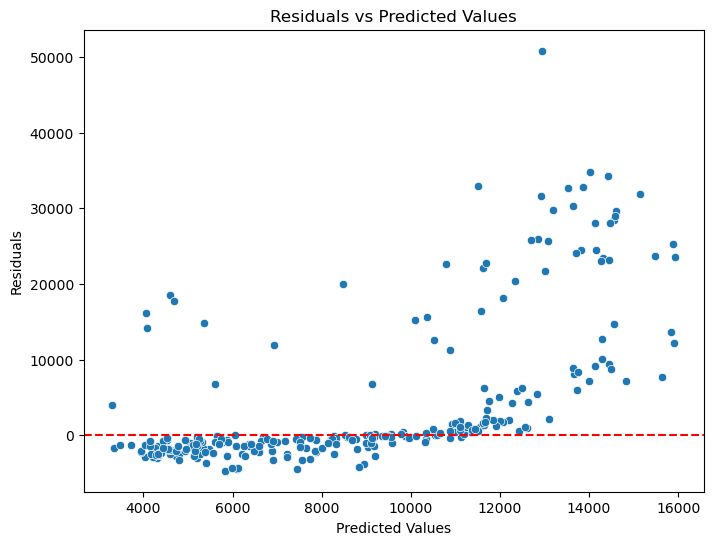

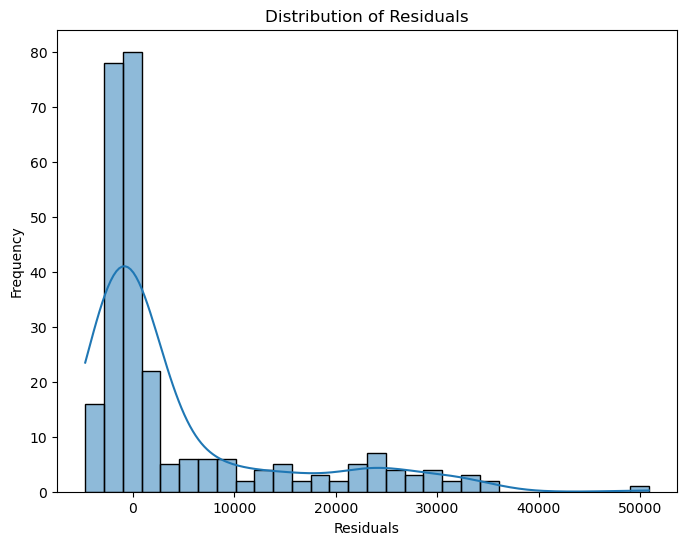

In [26]:
# model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)   
print(f'Model Evaluation Metrics:')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2 ): {r2:.2f}') 

# residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


# histogram of residuals
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



<Figure size 800x600 with 0 Axes>

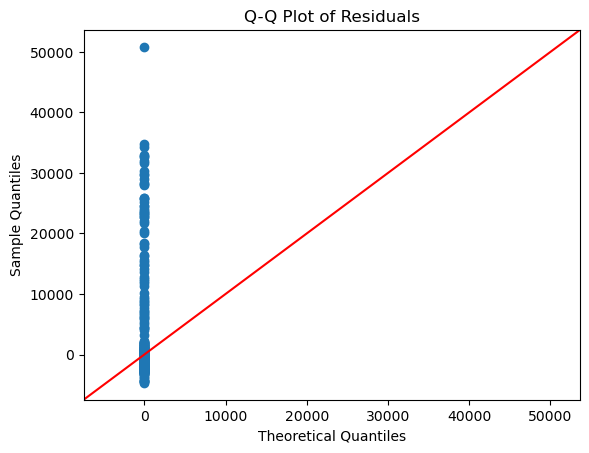

In [27]:
# Q-Q plot
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sm.qqplot(residuals, line ='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# feature importance

In [ ]:
# feature importance visualization is not feasible for SVR as it does not provide feature importance scores like tree-based models.

In [ ]:
# in summary, the SVR model has been trained, hyperparameters tuned, and evaluated using various metrics and visualizations.
# using different kernels and more extensive hyperparameter tuning could further improve performance.
